# Transformers

## References

* https://www.youtube.com/watch?v=eMlx5fFNoYc (3Blue1Brown)


## Architecture

![transformers](./images/Arch_Transformers.png)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

## Embedding

Creating dummy encodings here to replicate the effect of any embedding model

### Tokens 

Sentence - `I am new to NLP with Deep Learning.`

Convinient Lie - `I|am|new|to|NLP|with|Deep|Learning|.`

Actual Truthe - `I |am |new |to N|LP |with D|eep |Learn|ing.`

In [2]:
paragraph = """I am new to NLP with deep learning. I like Deep Learning and I like NLP. I am trying to combine it."""
conversion = """Je suis nouveau en PNL avec l'apprentissage profond. J'aime le Deep Learning et j'aime la PNL. J'essaie de le combiner."""
bow = paragraph.lower().replace(".", "").split(" ") + conversion.lower().replace(
    ".", ""
).split(" ")
vocab = set(bow)

In [3]:
tokenizer = {val: idx for idx, val in enumerate(vocab)}

In [4]:
def sentence_separator(sentence):
    return sentence.lower().replace(".", "").split(" ")


def get_tokens(sentence):
    sentence_sep = sentence_separator(sentence)
    tokens = torch.Tensor([tokenizer[i] for i in sentence_sep]).type(torch.int32)
    return tokens


def get_embedding(tokens, dim=30):
    torch.manual_seed(123)
    embed = torch.nn.Embedding(len(vocab), dim)
    embedded_sentence = embed(tokens).detach()
    return embedded_sentence

In [5]:
sentence = "I like NLP"
tokens = get_tokens(sentence)
tokens

tensor([ 1, 22, 21], dtype=torch.int32)

In [6]:
get_embedding(tokens)

tensor([[-0.6315, -2.8400, -1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343,
         -0.4991, -1.0867,  0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,
          0.2662, -0.5850,  0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,
          1.0533,  0.1388,  2.2473, -0.8036, -0.2808,  0.7697],
        [ 0.6961,  0.3076, -1.1440, -0.5357, -0.3139,  0.7074, -0.9846,  0.2325,
         -0.5109, -1.0550,  0.0795,  1.2257,  1.7500, -0.2029, -0.6854,  1.4270,
         -0.3253,  0.7013, -0.1262, -1.2932,  0.4858,  1.1693,  0.2187, -0.9539,
          1.2004,  2.7040,  0.0263,  0.5223,  0.3042, -1.1535],
        [ 0.9371, -1.8408,  0.5539,  1.9170, -0.6074, -0.7221,  2.5328, -1.2669,
          1.1882,  0.1221, -1.1065,  1.2682,  0.3147, -0.9990, -0.5298, -1.1257,
         -1.5839,  0.1298,  1.8622, -0.7446,  0.3587,  0.8623,  0.9155,  1.0884,
          0.7310, -0.5469, -1.8025, -0.5228,  0.8150, -0.1398]])

## Positional Encoding

\begin{align*}
PE(pos, 2i) &= \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\ \\
PE(pos, 2i + 1) &= \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})
\end{align*}

* Single value of $i \in [0, d_{model})$ map both sine and cosine function
* values will reside in -1 and 1
* 10000 is a scaling value

In [7]:
def positional_encoding(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens)
    for i in range(int(d_model / 2)):
        denominator = math.pow(scale, (2 * i) / d_model)
        p[positions, 2 * i] = torch.sin(positions / denominator)
        p[positions, (2 * i) + 1] = torch.cos(positions / denominator)
    return p

In [8]:
pd.DataFrame(
    positional_encoding(4, 4, 100),
    columns=[f"dim {i}" for i in range(4)],
    index=[f"pos {i}" for i in range(4)],
)

,dim 0,dim 1,dim 2,dim 3
pos 0,0.000000,1.000000,0.000000,1.000000
pos 1,0.841471,0.540302,0.099833,0.995004
pos 2,0.909297,-0.416147,0.198669,0.980067
pos 3,0.141120,-0.989992,0.295520,0.955337


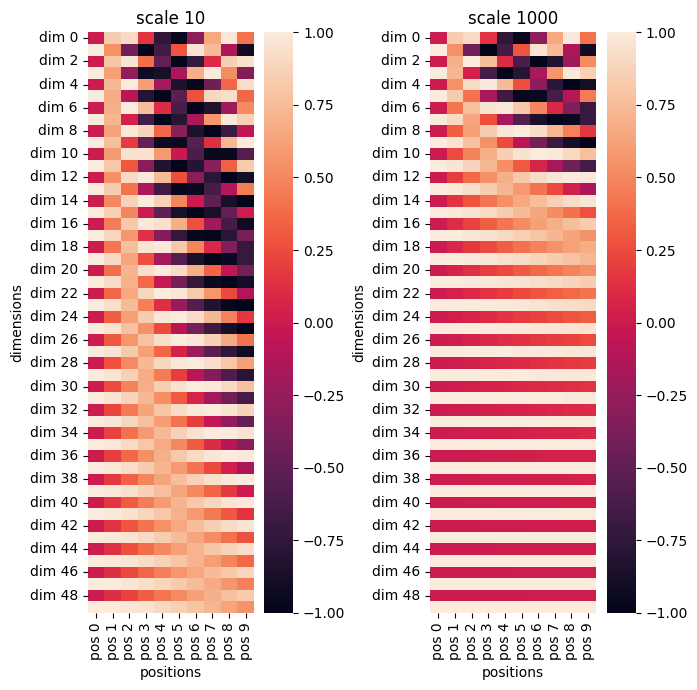

In [9]:
d_model = 50
n_tokens = 10


fig, ax = plt.subplots(1, 2, figsize=(7, 7))
pe = positional_encoding(d_model=d_model, n_tokens=n_tokens, scale=10)
sns.heatmap(
    pd.DataFrame(
        pe,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[0],
)
ax[0].set_title("scale 10")
ax[0].set_ylabel("dimensions")
ax[0].set_xlabel("positions")

pe = positional_encoding(d_model=d_model, n_tokens=n_tokens, scale=1000)
sns.heatmap(
    pd.DataFrame(
        pe,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[1],
)
ax[1].set_title("scale 1000")
ax[1].set_ylabel("dimensions")
ax[1].set_xlabel("positions")

plt.tight_layout()
plt.show()

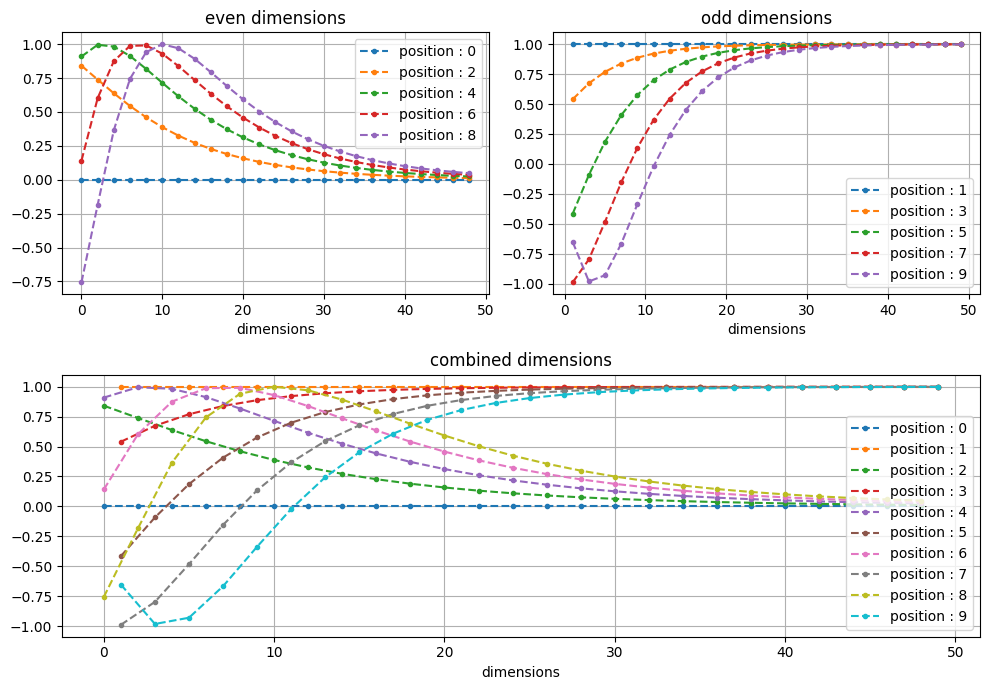

In [10]:
d_model = 50
n_tokens = 5
pe = positional_encoding(d_model=d_model, n_tokens=n_tokens, scale=100)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3, 4))
for i in range(n_tokens):
    ax1.plot(np.arange(0, d_model, 2), pe[i, 0::2], ".--", label=f"position : {2 * i}")
    ax2.plot(
        np.arange(1, d_model, 2), pe[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

for i in range(n_tokens):
    ax3.plot(np.arange(0, d_model, 2), pe[i, 0::2], ".--", label=f"position : {2 * i}")
    ax3.plot(
        np.arange(1, d_model, 2), pe[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

ax1.legend()
ax1.grid()
ax1.set_title("even dimensions")
ax1.set_xlabel("dimensions")

ax2.legend()
ax2.grid()
ax2.set_title("odd dimensions")
ax2.set_xlabel("dimensions")

ax3.legend(loc="best")
ax3.grid()
ax3.set_title("combined dimensions")
ax3.set_xlabel("dimensions")

plt.tight_layout()
plt.show()

## Embedding + Positional Encoding

In [11]:
sentence = "I am new to NLP with deep learning."

tokens = get_tokens(sentence)

In [12]:
n_tokens = len(tokens)
d_model = 10

pe = positional_encoding(n_tokens=n_tokens, d_model=d_model, scale=100)
df = pd.DataFrame(
    pe,
    columns=[f"dim {i}" for i in range(pe.shape[1])],
    index=[f"pos {i}" for i in range(pe.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,1,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
pos 1,am,24,0.841471,0.540302,0.387674,0.921796,0.157827,0.987467,0.063054,0.998010,0.025116,0.999685
pos 2,new,2,0.909297,-0.416147,0.714713,0.699417,0.311697,0.950181,0.125857,0.992048,0.050217,0.998738
pos 3,to,20,0.141120,-0.989992,0.929966,0.367644,0.457755,0.889079,0.188159,0.982139,0.075285,0.997162
pos 4,nlp,21,-0.756802,-0.653644,0.999766,-0.021631,0.592338,0.805690,0.249712,0.968320,0.100306,0.994957
pos 5,with,9,-0.958924,0.283662,0.913195,-0.407523,0.712073,0.702105,0.310272,0.950648,0.125264,0.992123
pos 6,deep,16,-0.279415,0.960170,0.683794,-0.729675,0.813960,0.580922,0.369596,0.929192,0.150143,0.988664
pos 7,learning,4,0.656987,0.753902,0.347443,-0.937701,0.895443,0.445176,0.427450,0.904039,0.174927,0.984581


In [13]:
embeddings = get_embedding(tokens, dim=d_model)

In [14]:
df = pd.DataFrame(
    embeddings,
    columns=[f"dim {i}" for i in range(embeddings.shape[1])],
    index=[f"pos {i}" for i in range(embeddings.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,1,0.698352,-1.409723,0.179380,1.895148,0.495446,0.269199,-0.077020,-1.020472,-0.168956,0.917765
pos 1,am,24,1.311315,-0.035963,0.211814,-0.008625,1.857613,2.132067,-0.505607,-0.798839,-1.094393,-1.019690
pos 2,new,2,1.580970,1.301040,1.275301,-0.200953,0.496471,-1.572304,0.966572,-1.148144,-1.158868,0.325471
pos 3,to,20,1.172068,-0.437163,-0.405275,0.708644,0.953313,-0.013035,-0.130088,-0.087660,-0.067349,0.246739
pos 4,nlp,21,-0.939173,-1.044773,1.278313,0.419027,-0.507273,-0.606229,-1.053245,1.838551,-0.109538,-0.331608
pos 5,with,9,0.903148,-0.721844,-0.595084,-0.711218,0.622965,-1.372882,-2.214989,-1.319310,-2.091499,0.962852
pos 6,deep,16,0.685080,2.002415,-0.546882,1.601420,-2.257698,-1.800945,0.701475,0.570284,-1.176598,-2.052359
pos 7,learning,4,0.880544,1.554159,0.626616,-0.175487,0.098284,-0.093507,0.266215,-0.585036,0.876837,1.622144


In [15]:
combined_emb = pe + embeddings
combined_emb

df = pd.DataFrame(
    combined_emb,
    columns=[f"dim {i}" for i in range(combined_emb.shape[1])],
    index=[f"pos {i}" for i in range(combined_emb.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,1,0.698352,-0.409723,0.179380,2.895148,0.495446,1.269199,-0.077020,-0.020472,-0.168956,1.917765
pos 1,am,24,2.152786,0.504339,0.599488,0.913172,2.015439,3.119534,-0.442553,0.199171,-1.069277,-0.020006
pos 2,new,2,2.490267,0.884893,1.990015,0.498464,0.808168,-0.622123,1.092428,-0.156096,-1.108651,1.324209
pos 3,to,20,1.313188,-1.427155,0.524692,1.076288,1.411067,0.876043,0.058070,0.894478,0.007936,1.243901
pos 4,nlp,21,-1.695976,-1.698416,2.278079,0.397397,0.085065,0.199461,-0.803533,2.806871,-0.009232,0.663349
pos 5,with,9,-0.055776,-0.438182,0.318111,-1.118740,1.335038,-0.670777,-1.904718,-0.368662,-1.966235,1.954975
pos 6,deep,16,0.405664,2.962585,0.136912,0.871745,-1.443738,-1.220023,1.071071,1.499476,-1.026455,-1.063695
pos 7,learning,4,1.537531,2.308061,0.974059,-1.113189,0.993727,0.351669,0.693665,0.319004,1.051764,2.606725


## Attention (SingleHead)

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png)

\begin{align*}
\text{Attention}(Q, K, V) &= \text{softmax}\big( \frac{Q K^T}{\sqrt{d_k}} \big)V \\ \\
Q &= W_Q. X  & q_i &= W_Q x_i \text{ where } i \in [1, T] \\ 
K &= W_K. X  & k_i &= W_K x_i \text{ where } i \in [1, T] \\ 
V &= W_V. X  & v_i &= W_V x_i \text{ where } i \in [1, T] \\ \\
\text{where } T &= \text{Number of tokens in the sentence}
\end{align*}

In [16]:
def softmax(x):
    if len(x.shape) == 1:
        x = x.view(1, -1)
    return x / torch.sum(x, axis=1).view(-1, 1)


softmax(torch.Tensor([1, 1, 1, 1])), softmax(torch.Tensor([[1, 1, 1, 1], [1, 2, 1, 4]]))

(tensor([[0.2500, 0.2500, 0.2500, 0.2500]]),
 tensor([[0.2500, 0.2500, 0.2500, 0.2500],
         [0.1250, 0.2500, 0.1250, 0.5000]]))

In [17]:
d_model = 30

sentence = "I am new to NLP with deep learning"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model)

In [18]:
d_query, d_key, d_value = 24, 24, 28

W_Q = torch.rand(d_query, d_model)
W_K = torch.rand(d_key, d_model)
W_V = torch.rand(d_value, d_model)

In [19]:
Q = torch.matmul(X, W_Q.T)
K = torch.matmul(X, W_K.T)
V = torch.matmul(X, W_V.T)

Q.shape, K.shape, V.shape

(torch.Size([8, 24]), torch.Size([8, 24]), torch.Size([8, 28]))

In [20]:
omega = softmax((Q @ K.T) / np.sqrt(d_key))

pd.DataFrame(
    omega,
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
)

,i,am,new,to,nlp,with,deep,learning
i,-0.070857,-0.449524,0.368447,0.344669,0.112864,0.357330,-0.232327,0.569398
am,-0.035283,-0.646358,0.412263,0.444236,-0.202983,0.587546,-0.182597,0.623176
new,0.027862,-0.499661,0.333724,0.332004,-0.050549,0.481687,-0.124678,0.499611
to,0.035334,-0.639098,0.383086,0.409214,-0.206646,0.592551,-0.169785,0.595343
nlp,-0.099127,-0.744016,0.523921,0.688555,-0.767360,0.970217,-0.161152,0.588962
with,-0.002471,-0.540764,0.398311,0.389394,-0.147333,0.517955,-0.150766,0.535674
deep,-0.051319,-0.731734,0.472085,0.472028,-0.220371,0.603764,-0.242718,0.698265
learning,0.004739,-0.646289,0.410346,0.419468,-0.180445,0.563467,-0.158849,0.587564


In [21]:
def attention(Q, K, V, d_key):
    return softmax((Q @ K.T) / np.sqrt(d_key)) @ V

In [22]:
attn_out = attention(Q, K, V, d_key)

attn_out.shape

torch.Size([8, 28])

In [23]:
df = pd.DataFrame(
    attn_out,
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=sentence_separator(sentence),
)
df

,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,...,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25,dim 26,dim 27
i,-7.813864,-8.949475,-6.829915,-5.003034,-6.337472,-7.110267,-8.300797,-7.114546,-6.204810,-7.175976,...,-7.845998,-6.598104,-7.178439,-8.155731,-8.720693,-5.104501,-9.413046,-6.085624,-4.321877,-7.177526
am,-10.245035,-10.746542,-9.417377,-6.134343,-9.425444,-10.654886,-10.474263,-9.961685,-8.261339,-9.099747,...,-12.024027,-7.447526,-9.652019,-11.249643,-10.809193,-6.865498,-11.772483,-8.845733,-6.125512,-9.649708
new,-7.786148,-8.195956,-7.268371,-4.677832,-6.910483,-8.040537,-8.480371,-7.479891,-6.539638,-6.913281,...,-8.980412,-6.088414,-7.365855,-8.581266,-8.757317,-5.853319,-9.308170,-6.730396,-4.936150,-7.598851
to,-9.879729,-10.122474,-9.158246,-5.711802,-9.053898,-10.527384,-10.309126,-9.650460,-7.891246,-8.680538,...,-11.746576,-7.103923,-9.342490,-10.832274,-10.555261,-6.964251,-11.338223,-8.631649,-6.121290,-9.471727
nlp,-13.181624,-13.339663,-12.494910,-7.828741,-13.986601,-14.874892,-12.708742,-13.541971,-11.820258,-11.569273,...,-18.176134,-8.081445,-12.344579,-15.596076,-12.828906,-8.087372,-14.364400,-12.834093,-8.448684,-12.125613
with,-8.797347,-9.302888,-8.132835,-5.289546,-8.038893,-9.087258,-9.140620,-8.530391,-7.376938,-7.769600,...,-10.363300,-6.643502,-8.218842,-9.660421,-9.476602,-6.125483,-10.174261,-7.641745,-5.381216,-8.263912
deep,-11.461595,-12.082056,-10.358124,-6.832441,-10.401862,-11.686748,-11.512852,-11.095046,-8.923754,-10.149482,...,-13.166249,-8.334330,-10.739090,-12.364110,-11.919968,-7.416999,-12.955627,-9.676226,-6.641562,-10.573349
learning,-9.803741,-10.148295,-9.080699,-5.795418,-9.004504,-10.305947,-10.090765,-9.574106,-7.920774,-8.598804,...,-11.530605,-7.273567,-9.237000,-10.714206,-10.473424,-6.837180,-11.272622,-8.480933,-5.943303,-9.308289


## MultiHead Attention

![multi-head-attention](./images/Arch_MultiHeadAttention.png)

## Masked-MultiHead Attention

* mask the tokens that come in next steps (as -inf)
* so that softmax converts them to zero
* In cases of chatbot, the algorithm should not know the next word at the time of training
* so that it can predict the probability of next word based on target values and hadn't seen the value before